In [1]:
import warnings
import numpy as np
from pymilvus import (
    connections, Collection,
    FieldSchema, CollectionSchema, DataType,
    utility
)
from sentence_transformers import SentenceTransformer

In [2]:
# ※ <> で囲まれた部分は、実行時に修正ください
connections.connect(
            alias='default',
            host="<HostName>",
            port="<Port>",
            secure=True,
            user="<User_Name>",
            password="<API_Key>"
)

print("Milvusサーバーに接続しました。接続タイプ : "+utility.get_server_type())

Milvusサーバーに接続しました。接続タイプ : milvus


In [3]:
# フィールドスキーマ
book_id = FieldSchema(name="book_id", dtype=DataType.INT64, is_primary=True, auto_id=True)
title = FieldSchema(name="title", dtype=DataType.VARCHAR, max_length=200)
embedding = FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=384)  # all-MiniLM-L6-v2の次元数

# コレクションスキーマ
schema = CollectionSchema(
    fields=[book_id, title, embedding],
    description="書籍検索用コレクション"
)

# コレクション作成
collection_name = "demo_books"
print(f"コレクション '{collection_name}' が既に存在する場合は、一度削除して新たに作成します")
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

collection = Collection(name=collection_name, schema=schema)
print(f"コレクション '{collection_name}' を作成しました")

コレクション 'demo_books' が既に存在する場合は、一度削除して新たに作成します
コレクション 'demo_books' を作成しました


In [4]:
# サンプルデータ
titles = [
    "Pythonで学ぶ機械学習",
    "Milvusを使ったベクトル検索",
    "深層学習の基礎理論",
    "自然言語処理入門",
    "推薦システムの実装",
    "データサイエンスのための統計学",
    "クラウドコンピューティング入門",
    "DockerとKubernetesの実践",
    "ブロックチェーン技術の基礎",
    "DevOpsハンドブック",
    "AIエンジニアのキャリアパス",
    "フロントエンド開発の最新動向",
    "サイバーセキュリティ対策",
    "量子コンピューティング概論",
    "IoTシステム設計"
]

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*`encoder_attention_mask` is deprecated.*"
)

# 埋め込みモデルのロード
model = SentenceTransformer('all-MiniLM-L6-v2')

# ベクトル生成
embeddings = model.encode(titles).tolist()

# データ挿入
collection.insert([titles, embeddings])
collection.flush()
print(f"{len(titles)}件のデータを挿入しました")

15件のデータを挿入しました


In [5]:
# ベクトルフィールドにインデックスを作成
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "COSINE",  # コサイン類似度
    "params": {"nlist": 128}
}

collection.create_index(
    field_name="embedding",
    index_params=index_params
)

# インデックス作成後にコレクションをロード
collection.load()
print("インデックスを作成し、コレクションをロードしました")

インデックスを作成し、コレクションをロードしました


In [6]:
# 投入データの確認
def show_collection_data_with_vectors(collection, limit=5):
    # データを取得（全フィールドを取得）
    res = collection.query(
        expr="",
        offset=0,
        limit=limit,
        output_fields=["book_id", "title", "embedding"],  # embeddingフィールドを追加
        consistency_level="Strong"
    )
    
    print(f"\nコレクション '{collection.name}' のデータ（最新{len(res)}件）:")
    for idx, item in enumerate(res, 1):
        print(f"{idx:2d}. ID: {item['book_id']}")
        print(f"    タイトル: {item['title']}")
        print(f"    ベクトル: {item['embedding'][:5]}...")  # ベクトルは先頭の5次元のみ表示
        
show_collection_data_with_vectors(collection, limit=5)


コレクション 'demo_books' のデータ（最新5件）:
 1. ID: 459747783103923971
    タイトル: Pythonで学ぶ機械学習
    ベクトル: [0.010484549, 0.123188205, 0.03924857, -0.0067915204, -0.019120567]...
 2. ID: 459747783103923972
    タイトル: Milvusを使ったベクトル検索
    ベクトル: [0.015881399, 0.08229286, 0.05056868, 0.043223873, 0.03599267]...
 3. ID: 459747783103923973
    タイトル: 深層学習の基礎理論
    ベクトル: [0.024278017, 0.11785468, 0.061981846, 0.007292697, 0.0044225208]...
 4. ID: 459747783103923974
    タイトル: 自然言語処理入門
    ベクトル: [0.011214713, 0.033622418, 0.06311778, 0.0062758187, -0.08266385]...
 5. ID: 459747783103923975
    タイトル: 推薦システムの実装
    ベクトル: [-0.014305522, 0.09250768, 0.016126176, -0.063117884, -0.04298469]...


(参考)
Attu等によりデータを確認することも可能です  
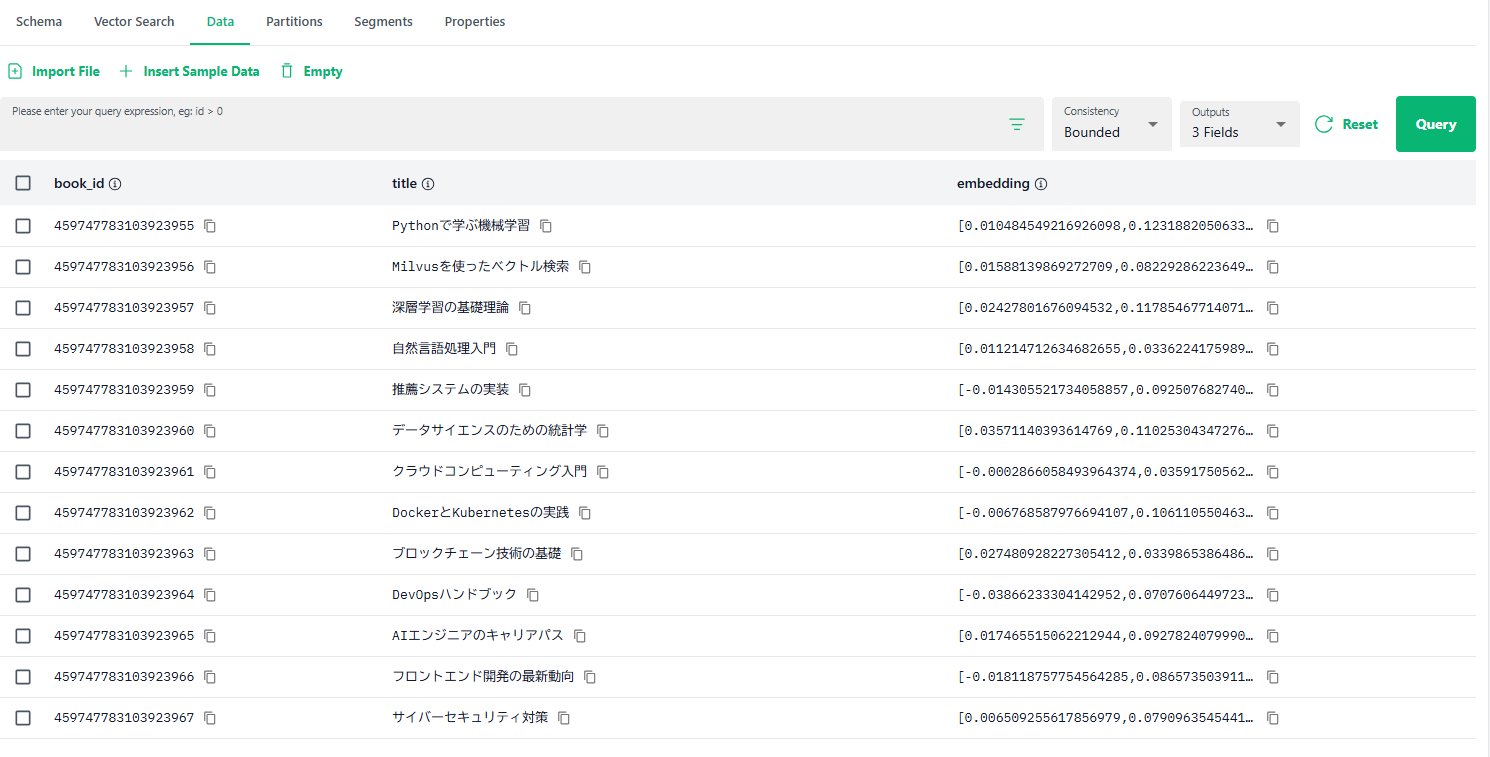



In [7]:
# 検索の実行
def vector_search(collection, query_text, model, top_k=3):
    query_embedding = model.encode([query_text])[0].tolist()
    
    results = collection.search(
        data=[query_embedding],
        anns_field="embedding",
        param={"metric_type": "COSINE", "params": {"nprobe": 10}},
        limit=top_k,
        output_fields=["title"]
    )
    
    print(f"\n検索クエリ: '{query_text}'")
    for i, hit in enumerate(results[0]):
        print(f"{i+1}. {hit.entity.title} (類似度: {hit.score:.3f})")

# 検索例
vector_search(collection, "機械学習のチュートリアル", model)
vector_search(collection, "データベース管理システムとは", model)
vector_search(collection, "サーバー管理者の基礎知識", model)


検索クエリ: '機械学習のチュートリアル'
1. データサイエンスのための統計学 (類似度: 0.721)
2. 深層学習の基礎理論 (類似度: 0.685)
3. ブロックチェーン技術の基礎 (類似度: 0.647)

検索クエリ: 'データベース管理システムとは'
1. 推薦システムの実装 (類似度: 0.854)
2. ブロックチェーン技術の基礎 (類似度: 0.713)
3. データサイエンスのための統計学 (類似度: 0.686)

検索クエリ: 'サーバー管理者の基礎知識'
1. サイバーセキュリティ対策 (類似度: 0.728)
2. ブロックチェーン技術の基礎 (類似度: 0.713)
3. 量子コンピューティング概論 (類似度: 0.683)
